# Celebrity Faces: Applying CNN for Gender Detection

## Group Members:
### Kristian Stavad, Lasse Hede, Rasmus S. Hye.

# Step 1: Data Exploration

In the first step, we explore our dataset, and make changes to the data, in order to prepare the data for further analysis.

This includes importing the necessary libraries, changing dataset values and general exploration of the dataset. 

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import f1_score
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Model 
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, Input
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.utils import np_utils

from IPython.core.display import display
from PIL import Image

plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Mount Google Drive to access data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Unzip image folder to access image data, and store it in new 
# folder (img_align_celeba)

import zipfile
with zipfile.ZipFile('gdrive/My Drive/M3_Group_Assignment/img_align_celeba.zip',
                     'r') as zip_ref:
    zip_ref.extractall('img_align_celeba')


In [0]:
# Set variables
root_folder = 'gdrive/My Drive/M3_Group_Assignment/'
img_folder = 'img_align_celeba/img_align_celeba/'

#Memory limitation, so we use a reduced amount of data, to train and validate.
train_size = 10000
val_size = 2000

#We set test-size as 2.000
test_size = 2000

#Predefine image size
img_width = 178
img_height = 218

#Set batch_size to 16, to reduce memory.
#Too large batch-size can negatively affect accuracy.
batch_size = 16

#Set epochs as 20 
n_epochs = 20

In [5]:
#Import the dataset that includes the attribute for each picture
data_attr = pd.read_csv(root_folder + 'list_attr_celeba.csv')
data_attr.set_index('image_id', inplace=True)
data_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
data_attr.shape
data_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [6]:
#We now print a list of available attributes, to get an insight of the 
#possible attributes in the dataset.
for i, j in enumerate(data_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Bald     0
Male     1
Young    1
Name: 000409.jpg, dtype: int64

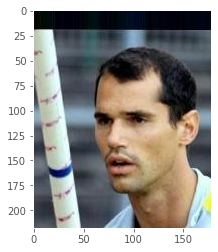

In [7]:
#First we want to see an example of one picture, and we therefore print
#an example of a picture. We just chose a random picture. 
#We also try to print some attributes, to see if they match the picture.
#In this case we check for 'Bald', 'Male' and 'Young'.
ex_pic = img_folder + '000409.jpg'
img = load_img(ex_pic)
plt.grid(False)
plt.imshow(img)
data_attr.loc[ex_pic.split('/')[-1]][['Bald','Male','Young']] #some attributes

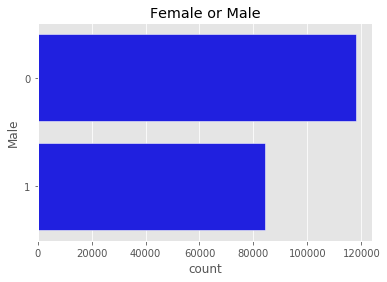

In [8]:
# To get an insight of the data distribution of male and female pictures
# we print a barchart with true/false labels for 'Male'.
# False values = Females
# True values = Males
plt.title('Female or Male')
sns.set_style('whitegrid')
sns.countplot(y='Male', data=data_attr, color="b")

plt.show()

# Step 2: Split Dataset into Training, Validation and Test

For this step we divide our dataset into three subsets of the dataframe, which is training, validation and test samples. In order to reduce time execution, we limit our splits as:
- Training: 20.000 images
- Validation: 5.000 images
- Test: 5.000 images

This way we train our data on ~66% of the dataset, validate on ~17% of the dataset and test on ~17% of the dataset.

The splitting of the data is predefined in the 'list_eval_partition.csv' dataset. 

In [9]:
# We import the predefined partition data, where 
# partition: 0 = training
# partition: 1 = validation
# partition: 2 = test
data_partition = pd.read_csv(root_folder + 'list_eval_partition.csv')
data_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [10]:
# We display the distribution of train, validation and test in the
# predefined dataset.
data_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [11]:
# We add the column 'Male' from data_attr dataframe, to identify gender on 
# each partition, and print out the first five values.
# The number of images needs to be balanced, in order to get a good performance
# for the model
data_partition.set_index('image_id', inplace=True)
data_par_attr = data_partition.join(data_attr['Male'], how='inner')
data_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [0]:
#Now we create some functions, to be used later in the notebook.

#We make a function to reshape the images, after they have been processed
#through the generate_data function, which is defined below this function.
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

#The generate_data function generates data based on a partition, attributes and
#samples. This is done by generating data on train and validation and on test. 
def generate_data(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    dataframe = data_par_attr[(data_par_attr['partition'] == partition) 
                           & (data_par_attr[attr] == 0)].sample(int(num_samples/2))
    dataframe = pd.concat([dataframe,
                      data_par_attr[(data_par_attr['partition'] == partition) 
                                  & (data_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(img_folder + fname) for fname in dataframe.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(dataframe[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in dataframe.iterrows():
            im = cv2.imread(img_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (img_width, img_height)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

# Step 3: Pre-processing images: Data Augmentation

In order to be able to make better predictions, we process the images with modifications to the original ones, by mirroring, stretching, scaling etc. the images. The model will this way learn from these different variations, resulting in better predictions on images it has never seen before.

Below is an image example on how a picture will look like after data augmentation.

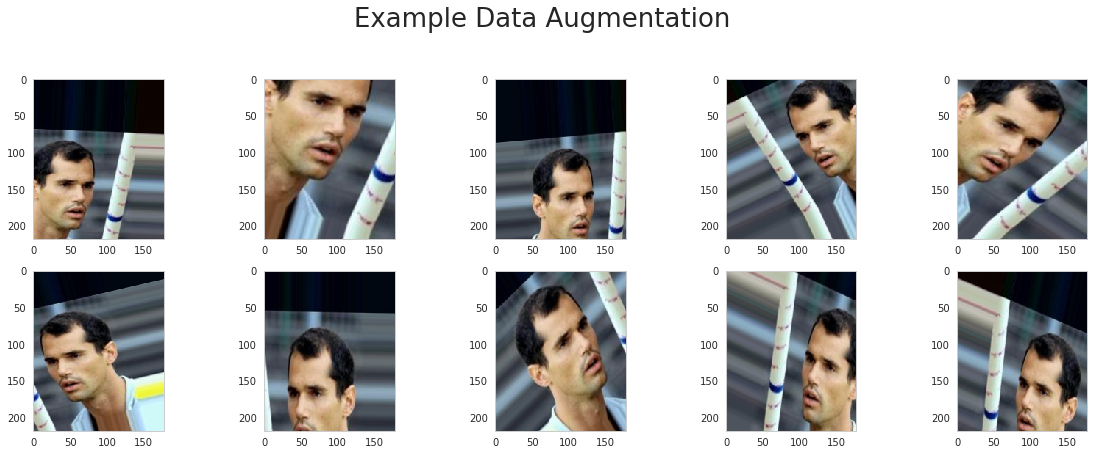

In [13]:
# We generate image generator for data augmentation with 
# the ImageDataGenerator function below
dataGenerator =  ImageDataGenerator(
  rotation_range=40,
  width_shift_range=0.3,
  height_shift_range=0.3,
  shear_range=0.3,
  zoom_range=0.3,
  horizontal_flip=True
)

# We use ex_pic as example for the data augmentation
img = load_img(ex_pic)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# We then plot 10 augmented images of the loaded image to see the behavior of
# the data augmentation
plt.figure(figsize=(20,10))
plt.suptitle('Example Data Augmentation', fontsize=26)

i = 0
for batch in dataGenerator.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()


In [0]:
# Define the train data
x_train, y_train = generate_data(0, 'Male', train_size)

# Train - Data Preparation for data augmentation
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=40,
  width_shift_range=0.3,
  height_shift_range=0.3,
  shear_range=0.3,
  zoom_range=0.3,
  horizontal_flip=True,
)

#fitting the model
train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=batch_size,
)

In [0]:
# Define validation Data
x_valid, y_valid = generate_data(1, 'Male', val_size)

# Step 4: Build the Model - Gender Recognition
In this step we build the model for the Gender detection through image recognition. We apply the Google-made InceptionV3 transfer-learning model. On top of this layer-architecture, we add our custom layers, for improving performance within our problem-scope.

We then train the model through a number of epochs.

Lastly in this step, we plot the loss function value and accuracy through the different epochs, and make a test

In [16]:
# Import InceptionV3 Model
# The inceptionV3 is a Google made transfer-learning model, which is the most
# popular model for image recognition, and is trained on over 1 million pictures
inc_model = InceptionV3(weights= root_folder + 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(img_height, img_width, 3))

#Print the number of layers in the architecture. We did outcomment the summary
#function, to save space (it takes a lot of space to print 311 layers)
print("number of layers:", len(inc_model.layers))
#inc_model.summary()














number of layers: 311


In [17]:
#We add our custom layers to fit the model to our problem-scope

x = inc_model.output
#Add GlovalAveragePooling2D to apply a two-dimensional output to the 
#kernel-size, to produce a tensor with dimensions.
x = GlobalAveragePooling2D()(x)
#We add a Dense layer which is a linear operation in which every input is 
#connected to every output by a weight
x = Dense(1024, activation="relu")(x)
#Add dropout layer, to add 'braindamage' to prevent overfitting
x = Dropout(0.5)(x)
#Add second Dense layer
x = Dense(512, activation="relu")(x)
#Define prediction as the full-model, with a Dense-layer
#and 'sigmoid' as activation, because of the binary problem-statement.
predictions = Dense(2, activation="sigmoid")(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
# creating the final model with inc_model.input as input and 
#our defined predictions as output.
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]: 
    layer.trainable = False

# compile the model
model_.compile(optimizer='adam'
                    , loss='binary_crossentropy'
                    , metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#We use ModelCheckpoint to create a filepath, which later will save the best 
#model from the training session.
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5',
                               verbose=1, save_best_only=True)

In [20]:
#We execute our training session, and store it as hist variable.
# We calculate steps_per_epoch as train_size divided by batch_size, to ensure
# that we train on all data in each epoch.
# We use 20 epochs to get a proper amount of epochs for the training session, 
# which then stores the best model for the test session through the callback. 
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= train_size/batch_size
                      , epochs= n_epochs
                      , callbacks=[checkpointer]
                      , verbose=1
                    )



Epoch 1/20
625/625 [==============================] - 118s 188ms/step - loss: 0.3464 - acc: 0.8654 - val_loss: 1.7052 - val_acc: 0.6272

Epoch 00001: val_loss improved from inf to 1.70523, saving model to weights.best.inc.male.hdf5
Epoch 2/20
625/625 [==============================] - 98s 157ms/step - loss: 0.2241 - acc: 0.9188 - val_loss: 0.7210 - val_acc: 0.8197

Epoch 00002: val_loss improved from 1.70523 to 0.72100, saving model to weights.best.inc.male.hdf5
Epoch 3/20
625/625 [==============================] - 99s 158ms/step - loss: 0.1951 - acc: 0.9263 - val_loss: 0.3084 - val_acc: 0.8955

Epoch 00003: val_loss improved from 0.72100 to 0.30837, saving model to weights.best.inc.male.hdf5
Epoch 4/20
625/625 [==============================] - 98s 158ms/step - loss: 0.1907 - acc: 0.9338 - val_loss: 0.6296 - val_acc: 0.7827

Epoch 00004: val_loss did not improve from 0.30837
Epoch 5/20
625/625 [==============================] - 99s 158ms/step - loss: 0.1738 - acc: 0.9375 - val_loss:

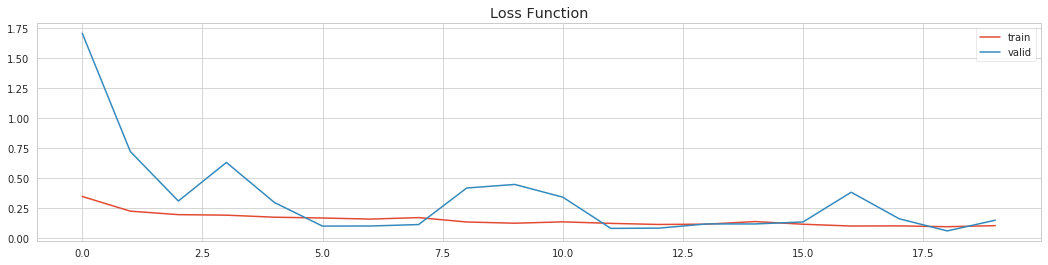

In [21]:
# We plot the loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

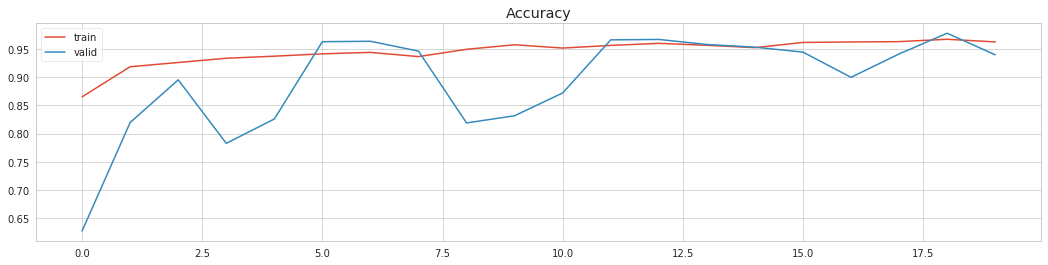

In [22]:
# We plot the accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [0]:
# We then load in the best model, which is stored in the 
# 'weights.best.inc.male.hdf5' file.
model_.load_weights('weights.best.inc.male.hdf5')

In [24]:
# Define the test data
x_test, y_test = generate_data(2, 'Male', test_size)

# Generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 97.0000%
f1_score: 0.9696356275303644
